In [172]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.axes import Axes
from pathlib import Path
from typing import Optional

In [2]:
polygon_path = Path(os.getenv("DATA_PATH")) / "polygons"

In [75]:
label_map = {
    "01.1.01":	"aguascalientes",
    "02.1.01":	"tijuana",
    "02.2.02":	"ensenada",
    "02.2.03":	"mexicali",
    "03.2.01":	"la paz",
    "03.2.02":	"los cabos",
    "04.2.01":	"campeche",
    "05.1.01":	"la laguna",
    "05.1.02":	"monclova-frontera",
    "05.1.03":	"piedras negras",
    "05.1.04":	"saltillo",
    "06.1.01":	"colima-villa de álvarez",
    "07.1.01":	"tapachula",
    "07.1.02":	"tuxtla gutiérrez",
    "08.1.01":	"chihuahua",
    "08.1.02":	"delicias",
    "08.2.03":	"ciudad juárez",
    "09.1.01":	"ciudad de méxico",
    "10.2.01":	"durango",
    "11.1.01":	"celaya",
    "11.1.02":	"león",
    "11.2.03":	"guanajuato",
    "11.2.04":	"irapuato",
    "12.1.01":	"chilpancingo",
    "12.2.02":	"acapulco",
    "13.1.01":	"pachuca",
    "13.1.02":	"tulancingo",
    "14.1.01":	"guadalajara",
    "14.1.02":	"puerto vallarta",
    "15.1.01":	"toluca",
    "16.1.01":	"la piedad-pénjamo",
    "16.1.02":	"morelia",
    "16.1.03":	"zamora",
    "16.2.04":	"uruapan",
    "17.1.01":	"cuautla",
    "17.1.02":	"cuernavaca",
    "18.1.01":	"tepic",
    "19.1.01":	"monterrey",
    "20.1.01":	"oaxaca",
    "21.1.01":	"puebla-tlaxcala",
    "21.1.02":	"san martín texmelucan",
    "21.1.03":	"tehuacán",
    "22.1.01":	"querétaro",
    "23.1.01":	"cancún",
    "23.2.02":	"chetumal",
    "24.1.01":	"san luis potosí",
    "25.2.01":	"culiacán",
    "25.2.02":	"los mochis",
    "25.2.03":	"mazatlán",
    "26.1.01":	"guaymas",
    "26.2.02":	"ciudad obregón",
    "26.2.03":	"hermosillo",
    "26.2.04":	"nogales",
    "27.1.01":	"villahermosa",
    "28.1.01":	"reynosa",
    "28.1.02":	"tampico",
    "28.2.03":	"ciudad victoria",
    "28.2.04":	"matamoros",
    "28.2.05":	"nuevo laredo",
    "29.1.01":	"tlaxcala-apizaco",
    "30.1.01":	"coatzacoalcos",
    "30.1.02":	"córdoba",
    "30.1.03":	"minatitlán",
    "30.1.04":	"orizaba",
    "30.1.05":	"poza rica",
    "30.1.06":	"veracruz",
    "30.1.07":	"xalapa",
    "31.1.01":	"mérida",
    "32.1.01":	"zacatecas-guadalupe",
}

In [317]:
def calculate_error_df(source_path: Path, reference_col: str) -> pd.DataFrame:
    if reference_col == "ghsl":
        other_col = "census"
    elif reference_col == "census":
        other_col = "ghsl"
    else:
        raise Exception

    df_error = []
    for path in source_path.glob("*.gpkg"):
        df = gpd.read_file(path)
        df.columns = [c.casefold() for c in df.columns]
        error_tot = df[reference_col] - df[other_col]
        error = 1 - df[other_col] / df[reference_col]
        error = pd.DataFrame(zip(error, error_tot), columns=["error", "error_tot"])
        
        zone = path.stem
        if zone == "23.2.03":
            continue

        error["zone"] = label_map[zone].title()
        df_error.append(error)

    df_error = (
        pd.concat(df_error, ignore_index=True)
        .replace([np.inf, -np.inf], np.nan)
        .dropna(how="any")
        .set_index("zone")
        .assign(
            error_sq=lambda df: df.error**2,
            error_abs=lambda df: df.error.abs(),
        )
    )

    return df_error


def plot_errors(df_error: pd.DataFrame, index_order: list[str], *, ax: Axes, column: str="error", percent: bool=True):
    sns.boxplot(df_error, x="zone", y=column, legend=False, ax=ax, order=index_order, fliersize=0, width=0.6, whis=0, notch=False, medianprops={"lw": 2}, boxprops={"facecolor": "#85accc"},)
    ax.set_ylim(-1, 1)
    ax.tick_params("x", rotation=90)
    
    if percent:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    else:
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    
    ax.grid(alpha=0.4)

    ax.set_xlabel(None)

In [318]:
df_blocks_inside_ghsl = calculate_error_df(polygon_path / "blocks_inside_ghsl", reference_col="ghsl")
df_ghsl_inside_agebs = calculate_error_df(polygon_path / "ghsl_inside_agebs", reference_col="census")

index_order = df_blocks_inside_ghsl.groupby(level=0)["error"].median().sort_values(ascending=False).index

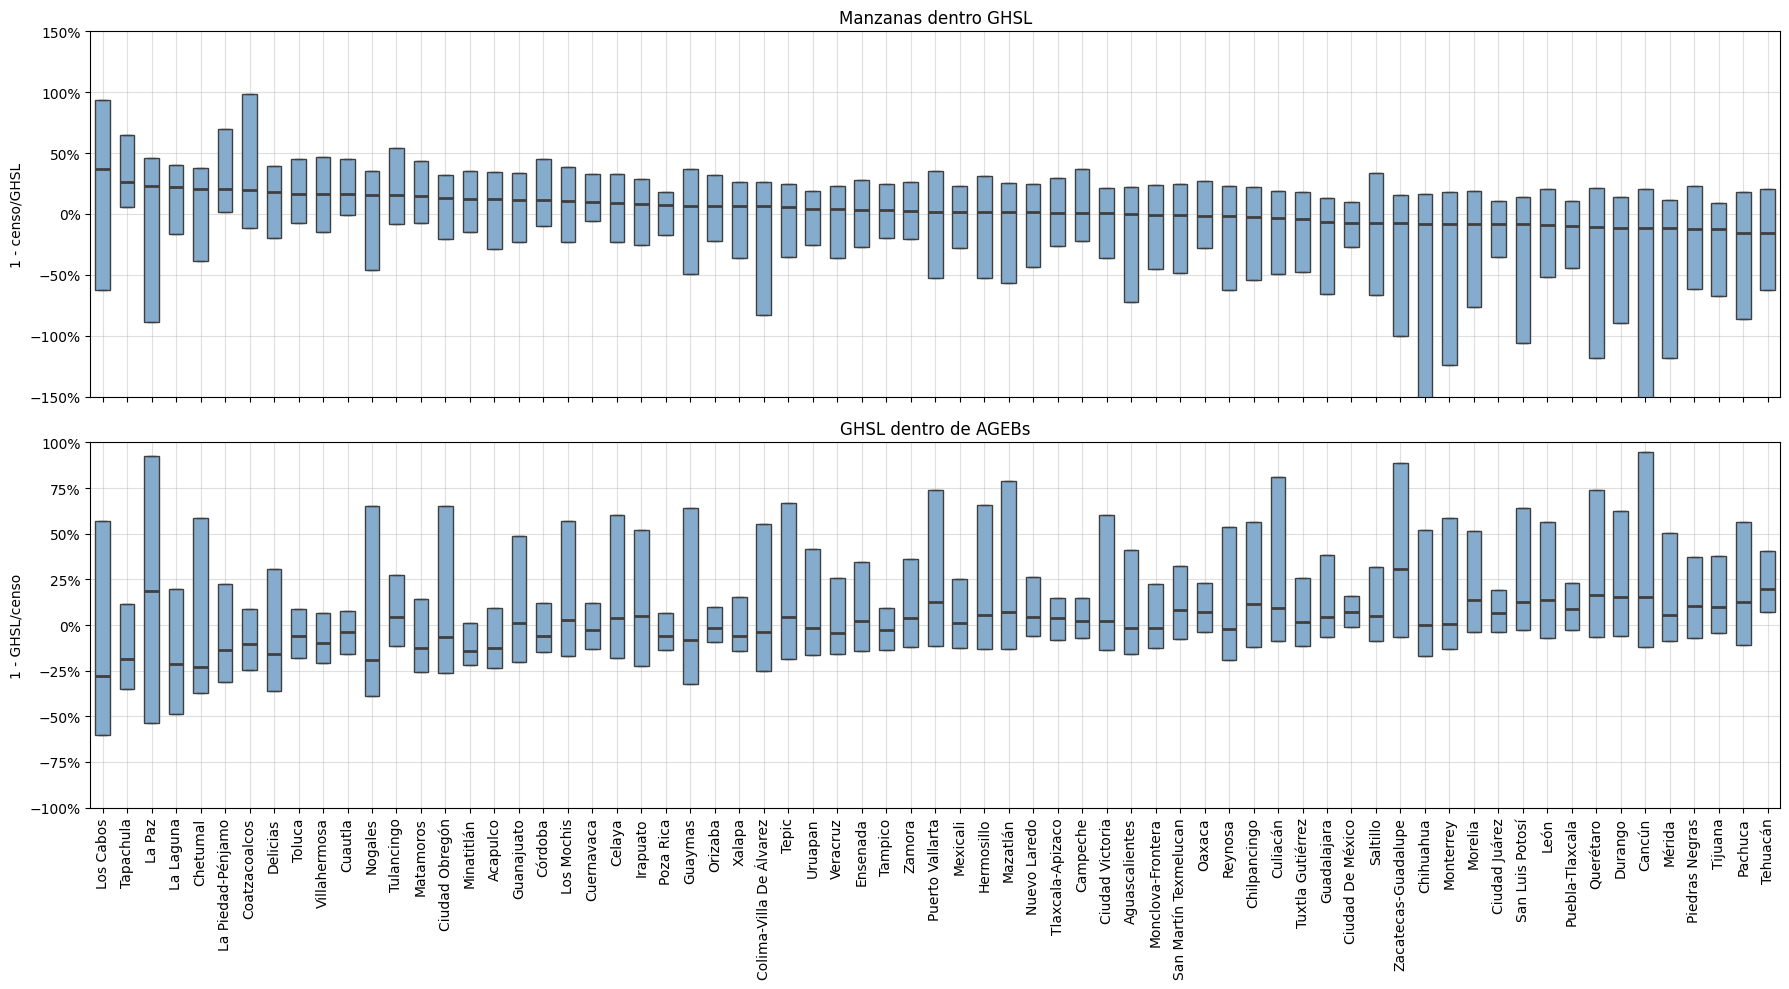

In [326]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

plot_errors(df_blocks_inside_ghsl, ax=ax1, index_order=index_order)
plot_errors(df_ghsl_inside_agebs, ax=ax2, index_order=index_order)

ax1.set_ylim(-1.5, 1.5)
ax2.set_ylim(-1, 1)

ax1.set_title("Manzanas dentro GHSL")
ax2.set_title("GHSL dentro de AGEBs")

ax1.set_ylabel("1 - censo/GHSL")
ax2.set_ylabel("1 - GHSL/censo")

fig.tight_layout()
fig.savefig("./figures/boxplot.jpg", bbox_inches="tight", dpi=200)

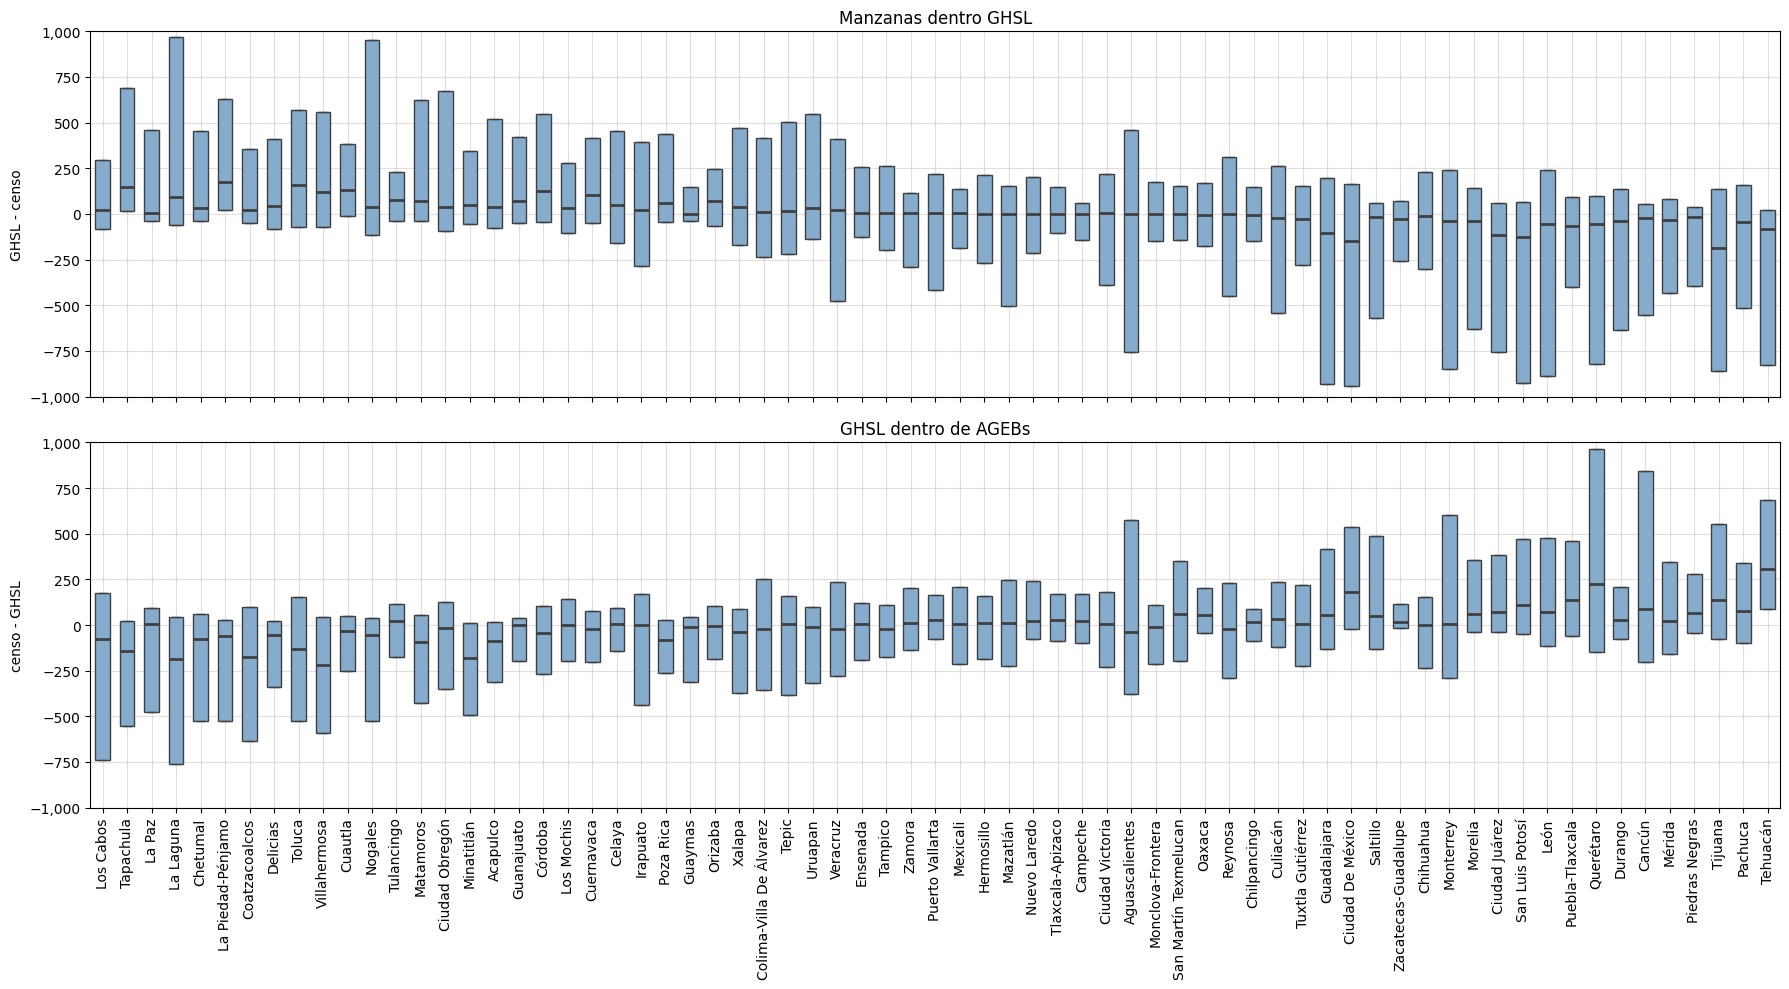

In [325]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

plot_errors(df_blocks_inside_ghsl, ax=ax1, index_order=index_order, column="error_tot", percent=False)
plot_errors(df_ghsl_inside_agebs, ax=ax2, index_order=index_order, column="error_tot", percent=False)

ax1.set_ylim(-1000, 1000)
ax2.set_ylim(-1000, 1000)

ax1.set_title("Manzanas dentro GHSL")
ax2.set_title("GHSL dentro de AGEBs")

ax1.set_ylabel("GHSL - censo")
ax2.set_ylabel("censo - GHSL")

fig.tight_layout()
fig.savefig("./figures/boxplot_abs.jpg", bbox_inches="tight", dpi=200)

In [321]:
def plot_mean_errors(df_error: pd.DataFrame, column: str, *, ax: Axes, log: bool):
    sns.barplot(df_error.groupby("zone")[column].mean(), width=0.6, order=index_order, facecolor="#85accc", ec="k", ax=ax)
    if log:
        ax.set_yscale("log")
    ax.tick_params("x", rotation=90)
    ax.grid(alpha=0.4)

    ax.set_xlabel(None)

def plot_all_mean_errors(df_error: pd.DataFrame, *, ax1: Axes, ax2: Axes, log1: bool=True, log2: bool=True):
    plot_mean_errors(df_error, "error_sq", ax=ax1, log=log1)
    plot_mean_errors(df_error, "error_abs", ax=ax2, log=log2)
    
    ax1.set_ylabel("Error cuadrático medio")
    ax2.set_ylabel("Error absoluto medio")

C:\Users\lain\AppData\Local\Temp\ipykernel_2856\1550928919.py:4: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 1_000_000)
C:\Users\lain\AppData\Local\Temp\ipykernel_2856\1550928919.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(0, 1000)


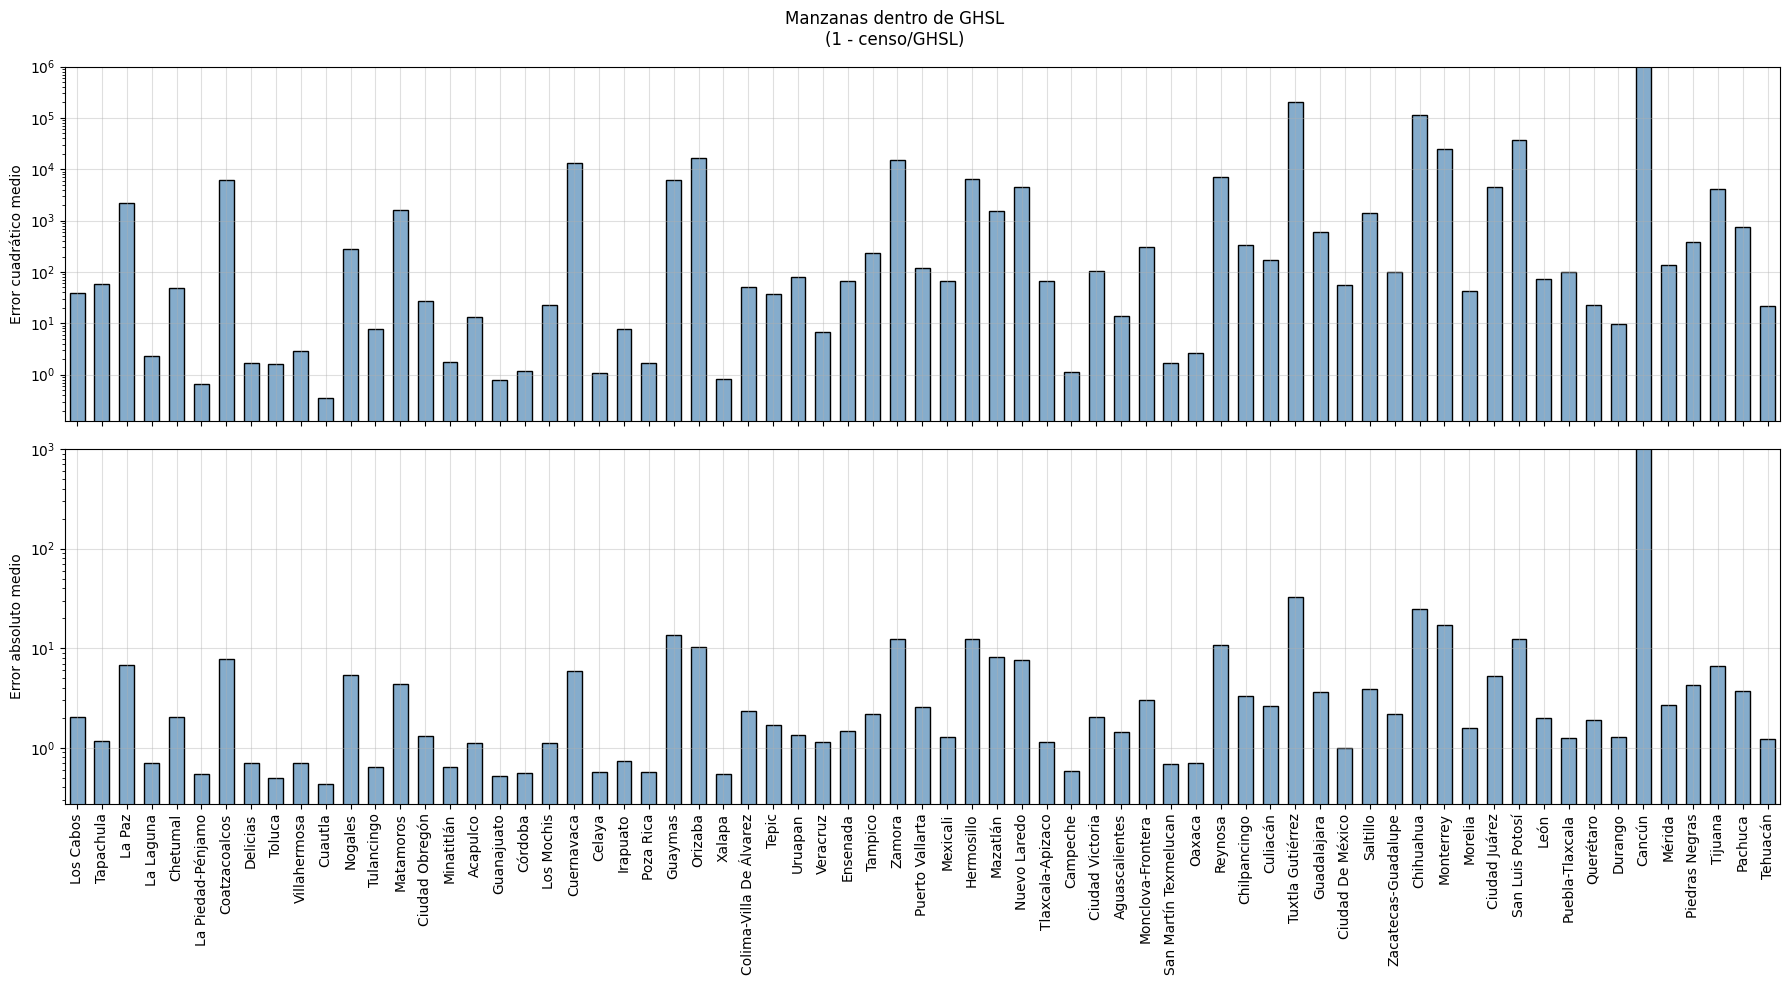

In [294]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
plot_all_mean_errors(df_blocks_inside_ghsl, ax1=ax1, ax2=ax2)

ax1.set_ylim(0, 1_000_000)
ax2.set_ylim(0, 1000)
fig.suptitle("Manzanas dentro de GHSL\n(1 - censo/GHSL)")
fig.tight_layout()
fig.savefig("./figures/bar_blocks_inside_ghsl.jpg", bbox_inches="tight", dpi=200)

C:\Users\lain\AppData\Local\Temp\ipykernel_2856\537151601.py:4: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 100)


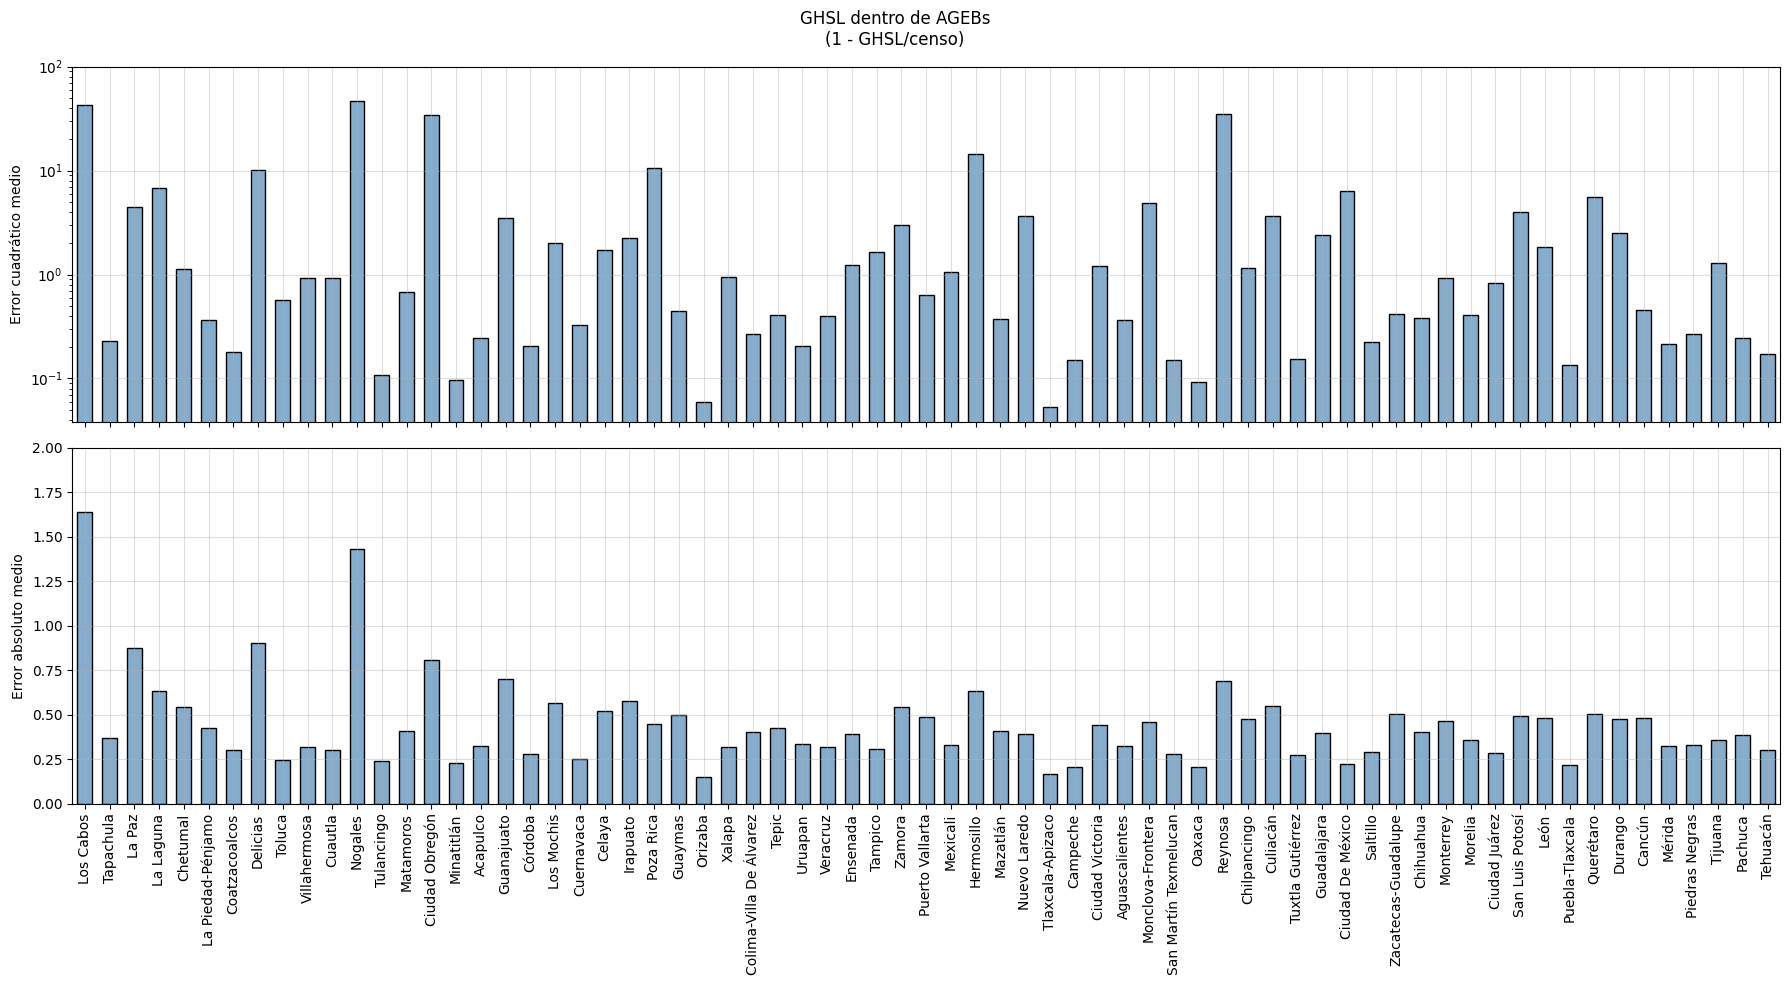

In [295]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
plot_all_mean_errors(df_ghsl_inside_agebs, ax1=ax1, ax2=ax2, log1=True, log2=False)

ax1.set_ylim(0, 100)
ax2.set_ylim(0, 2)
fig.suptitle("GHSL dentro de AGEBs\n(1 - GHSL/censo)")
fig.tight_layout()
fig.savefig("./figures/bar_ghsl_inside_agebs.jpg", bbox_inches="tight", dpi=200)